# TickMaster Project

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder.appName('ReadData').getOrCreate()
sc = spark.sparkContext

In [3]:
!ls /home/yuyangzh/final/

adwords1.csv	    data_purchase.csv		    final_03_11_v4.ipynb
adwords.csv	    data_purchase_SMALL1.csv	    final_03_11_v5.ipynb
adwords_SMALL1.csv  data_purchase_SMALL.csv	    ga_data.csv
adwords_SMALL.csv   final_03_11_v2 (big) (1).ipynb  ga_data_SMALL.csv


In [4]:
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

### Data import and Clean

In [5]:
# Read data_purchase.csv file
df0 = spark.read.csv("/user/jihunlee/final/data_purchase.csv", inferSchema=True, header=True)

In [6]:
# Convert columns to appropriate data types
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import unix_timestamp
df1 = df0.withColumn('sales_ord_tran_dt', unix_timestamp('sales_ord_tran_dt', 'yyyy-MM-dd').cast('timestamp'))
df1 = df1.withColumn('event_dt', unix_timestamp('event_dt', 'yyyy-mm-dd').cast('timestamp'))
df1 = df1.withColumn('presale_dt', unix_timestamp('presale_dt', 'yyyy-mm-dd').cast('timestamp'))
df1 = df1.withColumn('onsale_dt', unix_timestamp('onsale_dt', 'yyyy-mm-dd').cast('timestamp'))
df1 = df1.withColumn('event_date_time', unix_timestamp('event_date_time', 'yyyy-mm-dd hh:mm:ss').cast('timestamp'))
df1 = df1.withColumn('sales_ord_create_dttm', unix_timestamp('sales_ord_create_dttm', 'yyyy-mm-dd hh:mm:ss').cast('timestamp'))

In [7]:
df1 = df1.filter("timezn_nm like 'PST%' or timezn_nm like 'CST%' or timezn_nm like 'EST%' or timezn_nm like 'MST%'")

In [8]:
df1.printSchema()

root
 |-- event_id: string (nullable = true)
 |-- primary_act_id: string (nullable = true)
 |-- secondary_act_id: string (nullable = true)
 |-- purch_party_lkup_id: string (nullable = true)
 |-- event_name: string (nullable = true)
 |-- primary_act_name: string (nullable = true)
 |-- secondary_act_name: string (nullable = true)
 |-- major_cat_name: string (nullable = true)
 |-- minor_cat_name: string (nullable = true)
 |-- la_event_type_cat: string (nullable = true)
 |-- event_disp_name: string (nullable = true)
 |-- ticket_text: string (nullable = true)
 |-- tickets_purchased_qty: string (nullable = true)
 |-- trans_face_val_amt: string (nullable = true)
 |-- delivery_type_cd: string (nullable = true)
 |-- event_date_time: timestamp (nullable = true)
 |-- event_dt: timestamp (nullable = true)
 |-- presale_dt: timestamp (nullable = true)
 |-- onsale_dt: timestamp (nullable = true)
 |-- sales_ord_create_dttm: timestamp (nullable = true)
 |-- sales_ord_tran_dt: timestamp (nullable = true

In [9]:
# Drop "parking" column
df1 = df1.filter(df1['la_event_type_cat']!='PARKING')

In [10]:
# clean data - lower case
from pyspark.sql.functions import lower, col
df1 = df1.withColumn('event_name', lower(col('event_name'))).withColumn('major_cat_name', lower(col('major_cat_name'))).withColumn('minor_cat_name', lower(col('minor_cat_name'))).withColumn('venue_city', lower(col('venue_city')))

In [11]:
# clean data - remove whitespace
from pyspark.sql.functions import udf
charReplace = udf(lambda x: x.replace(u' ',''))
df1 = df1.withColumn('event_name',charReplace('event_name')).withColumn('major_cat_name',charReplace('major_cat_name')).withColumn('minor_cat_name',charReplace('minor_cat_name')).withColumn('venue_city',charReplace('venue_city'))
df1.show(3)

+--------------------+--------------------+--------------------+--------------------+----------+----------------+------------------+--------------+--------------+-----------------+---------------+--------------------+---------------------+------------------+----------------+-------------------+-------------------+----------+-------------------+---------------------+-------------------+----------+---------+----------+-----------+----------------------+--------------------+---------+----------------------+----------+----------------------+-------+------+----------+-------+----------------+----------------+----------------+-----------+-----------------+--------------+---------+-------------+-------------+-----------+
|            event_id|      primary_act_id|    secondary_act_id| purch_party_lkup_id|event_name|primary_act_name|secondary_act_name|major_cat_name|minor_cat_name|la_event_type_cat|event_disp_name|         ticket_text|tickets_purchased_qty|trans_face_val_amt|delivery_type_cd| 

### Price Optimization

#### Analysis By Event Name

In [12]:
# Drop columns
df2 = df1.drop("gndr_cd", "age_yr", "income_amt", "edu_val","edu_1st_indv_val","edu_2nd_indv_val","adults_in_hh_num","married_ind","child_present_ind","home_owner_ind","occpn_val","occpn_1st_val","occpn_2nd_val","dist_to_ven")
df2.count()

883743

In [13]:
#The most popular events
df2.groupby('event_name').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).show(5)

+--------------------+--------------------------+
|          event_name|sum(tickets_purchased_qty)|
+--------------------+--------------------------+
|beyonce-theformat...|                   73285.0|
|coldplay-aheadful...|                   38100.0|
|    davematthewsband|                   29390.0|
|        jimmybuffett|                   18573.0|
|          defleppard|                   17234.0|
+--------------------+--------------------------+
only showing top 5 rows



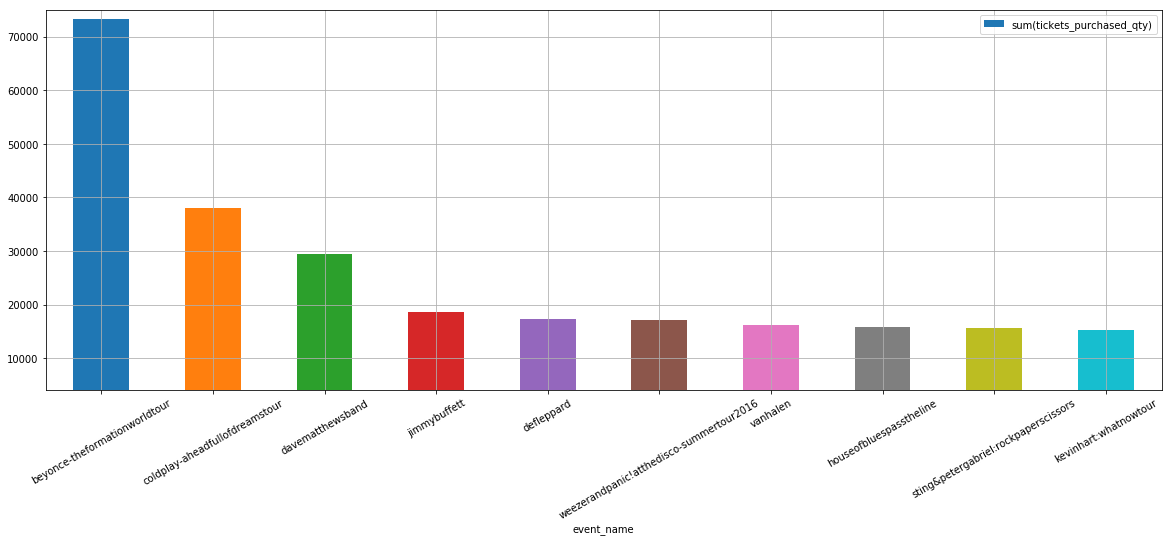

In [96]:
df_event = df2.groupby('event_name').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).limit(10)
pdf1 = df_event.toPandas()
# Bar chart - Top 10 events based on total purchased tickets amount
pdf1.plot(kind= 'bar', x='event_name', y='sum(tickets_purchased_qty)', figsize=(20,7), grid=True, rot=30, ylim=(4000, 75000))

#### Analysis By Event Category

In [15]:
#The most popular events type (major)
df2.groupby('major_cat_name').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).show(5)

+--------------+--------------------------+
|major_cat_name|sum(tickets_purchased_qty)|
+--------------+--------------------------+
|      concerts|                 1461120.0|
|          misc|                  409374.0|
|          arts|                   14391.0|
|        family|                    4980.0|
|        sports|                     944.0|
+--------------+--------------------------+
only showing top 5 rows



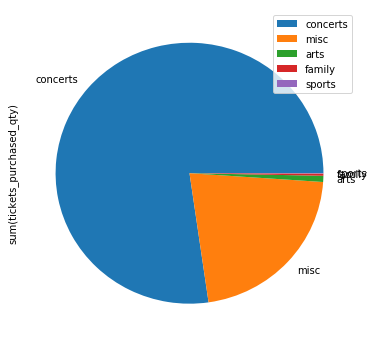

In [16]:
df_type = df2.groupby('major_cat_name').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).limit(5)
pdf2 = df_type.toPandas()
# Pie chart - Major event types based on total purchased tickets amount
pdf2.plot.pie(y='sum(tickets_purchased_qty)', labels = pdf2['major_cat_name'], figsize=(6, 6))

#### Analysis By Event Sub-Category

In [17]:
#The most popular events type (minor)
df2.groupby('minor_cat_name').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).show(5)

+--------------------+--------------------------+
|      minor_cat_name|sum(tickets_purchased_qty)|
+--------------------+--------------------------+
|            rock/pop|                  536780.0|
|     alternativerock|                  279913.0|
|specialentry(upsell)|                  223597.0|
|             country|                  184969.0|
|                 r&b|                  102426.0|
+--------------------+--------------------------+
only showing top 5 rows



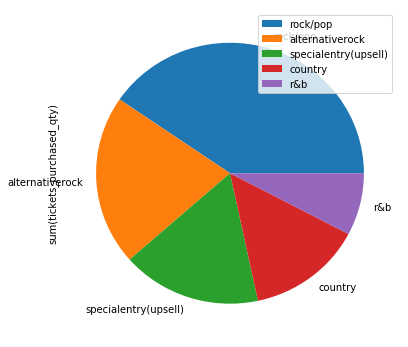

In [18]:
df_sub_type =df2.groupby('minor_cat_name').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).limit(5)
pdf2_sub = df_sub_type.toPandas()
# Pie chart - Major event types based on total purchased tickets amount
pdf2_sub.plot.pie( y='sum(tickets_purchased_qty)',labels = pdf2_sub['minor_cat_name'], figsize=(6, 6))

#### Analysis By Year, Month, Week and Date

In [19]:
# add 'Year' and 'Month' columns, and group by 'Year' and 'Month'
from pyspark.sql.functions import month, year
df_m = df2.withColumn('Year', year(df2['sales_ord_tran_dt']))
df_m = df_m.withColumn('Month', month(df_m['sales_ord_tran_dt']))
df_m3 = df_m.groupBy('Year','Month').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0, 0]).dropna()
df_m3.show(5)

+----+-----+--------------------------+
|Year|Month|sum(tickets_purchased_qty)|
+----+-----+--------------------------+
|2016|    2|                  348814.0|
|2015|    4|                  217177.0|
|2016|    1|                  213834.0|
|2015|    5|                  169341.0|
|2015|    7|                   73129.0|
+----+-----+--------------------------+
only showing top 5 rows



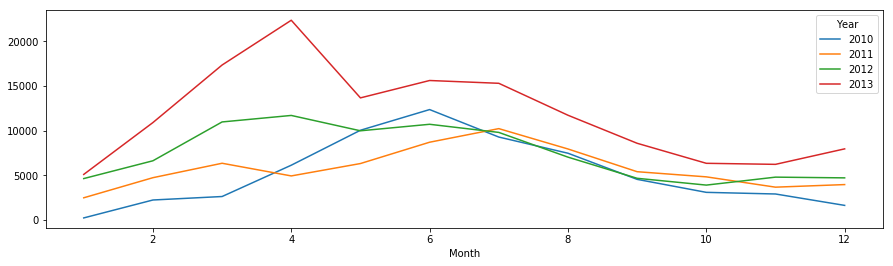

In [20]:
pdf3 = df_m3.filter("Year = 2011 or Year = 2012 or Year = 2013 or Year = 2010").toPandas()
pdf3 = pdf3.pivot(index='Month', columns='Year', values='sum(tickets_purchased_qty)')
pdf3
# line chart - historical monthly purchased tickets amount
pdf3.plot(figsize=(15,4))

In [21]:
# add 'Year' and 'Weekday'columns, and group by 'Year' and 'Weekday'
from pyspark.sql.functions import date_format
df5 = df2.withColumn('Weekday', date_format('sales_ord_tran_dt', 'E'))
df5 = df5.withColumn('Year', year(df2['sales_ord_tran_dt']))
df_week = df5.groupBy('Year', 'Weekday').agg(F.sum('tickets_purchased_qty')).orderBy(['Year', 'Weekday'], ascending=[0, 0])
df_week.show()

+----+-------+--------------------------+
|Year|Weekday|sum(tickets_purchased_qty)|
+----+-------+--------------------------+
|2016|    Wed|                   86339.0|
|2016|    Tue|                  100695.0|
|2016|    Thu|                   91454.0|
|2016|    Sun|                   29943.0|
|2016|    Sat|                   51967.0|
|2016|    Mon|                   73330.0|
|2016|    Fri|                  172995.0|
|2015|    Wed|                  138437.0|
|2015|    Tue|                  102312.0|
|2015|    Thu|                  160313.0|
|2015|    Sun|                   63711.0|
|2015|    Sat|                   98214.0|
|2015|    Mon|                  109168.0|
|2015|    Fri|                  200203.0|
|2014|    Wed|                     535.0|
|2014|    Tue|                     358.0|
|2014|    Thu|                     605.0|
|2014|    Sun|                     158.0|
|2014|    Sat|                     338.0|
|2014|    Mon|                    1079.0|
+----+-------+--------------------

In [22]:
# Which day of the week has the highest number of purchased tickets
df_week1 =df_week.groupBy('Weekday').agg(F.avg('sum(tickets_purchased_qty)')).dropna().sort("avg(sum(tickets_purchased_qty))").orderBy(["avg(sum(tickets_purchased_qty))"], ascending=[1])
df_week1.show()

+-------+-------------------------------+
|Weekday|avg(sum(tickets_purchased_qty))|
+-------+-------------------------------+
|    Sun|             11193.666666666666|
|    Sat|             17827.083333333332|
|    Mon|                       19436.75|
|    Tue|                       21087.25|
|    Wed|             23470.833333333332|
|    Thu|             26033.666666666668|
|    Fri|             38523.083333333336|
+-------+-------------------------------+



[Text(0,0,''),
 Text(0,0,'Sun'),
 Text(0,0,'Sat'),
 Text(0,0,'Mon'),
 Text(0,0,'Tue'),
 Text(0,0,'Wed'),
 Text(0,0,'Thu'),
 Text(0,0,'Fri')]

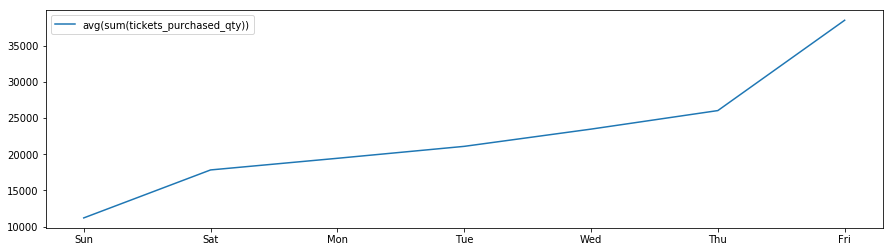

In [23]:
pdf3_week = df_week1.toPandas()
#pdf3_week = pdf3_week.pivot(index='Month', columns='Year', values='sum(tickets_purchased_qty)')
pdf3_1 = pdf3_week.plot(figsize=(15,4))
pdf3_1.set_xticklabels(('','Sun', 'Sat','Mon','Tue','Wed','Thu','Fri'))

In [24]:
#The date with highest tickets_purchased_qty
df2.groupby('sales_ord_tran_dt').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).show(6)

+-------------------+--------------------------+
|  sales_ord_tran_dt|sum(tickets_purchased_qty)|
+-------------------+--------------------------+
|2016-01-29 00:00:00|                   40495.0|
|2016-02-09 00:00:00|                   37571.0|
|2016-02-19 00:00:00|                   25321.0|
|2016-02-15 00:00:00|                   23824.0|
|2016-02-26 00:00:00|                   21609.0|
|2016-02-12 00:00:00|                   21212.0|
+-------------------+--------------------------+
only showing top 6 rows



In [25]:
# Which day of the week has the highest number of events
from pyspark.sql.functions import date_format
df5_1 = df2.withColumn('Weekday', date_format('event_dt', 'E'))
df5_1 = df5_1.withColumn('Year', year(df2['event_dt']))
df_eventdate = df5_1.drop_duplicates(subset=['event_id'])
df_eventdate1 = df_eventdate.groupBy('Year', 'Weekday').count().orderBy(['count'], ascending=[0, 0])
df_eventdate2 =df_eventdate1.groupBy('Weekday').agg(F.avg('count')).dropna().sort("avg(count)").orderBy(["avg(count)"], ascending=[1])
df_eventdate2.show()

+-------+------------------+
|Weekday|        avg(count)|
+-------+------------------+
|    Wed|275.07142857142856|
|    Sun|288.57142857142856|
|    Thu| 289.6923076923077|
|    Mon| 304.5833333333333|
|    Tue|             305.0|
|    Fri|313.38461538461536|
|    Sat| 337.0769230769231|
+-------+------------------+



[Text(0,0,''),
 Text(0,0,'Wed'),
 Text(0,0,'Sun'),
 Text(0,0,'Thu'),
 Text(0,0,'Mon'),
 Text(0,0,'Tue'),
 Text(0,0,'Fri'),
 Text(0,0,'Sat')]

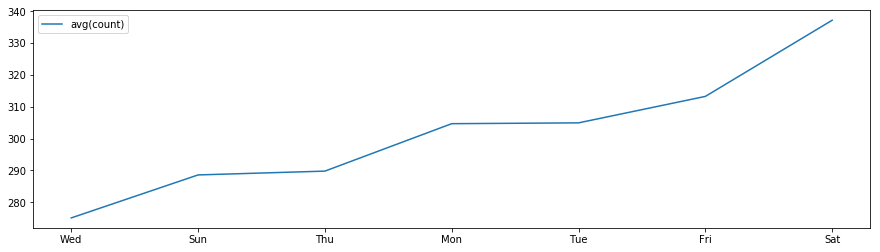

In [26]:
pdf3_eventdate = df_eventdate2.toPandas()
pdf3_2 = pdf3_eventdate.plot(figsize=(15,4))
pdf3_2.set_xticklabels(('','Wed', 'Sun','Thu','Mon','Tue','Fri','Sat'))

#### Analysis By Venue Cities

In [27]:
#count the number of venue_cities
df2.select('venue_city').distinct().count()

310

In [28]:
# remove the duplicate rows based on 'event_id'
df_city = df2.drop_duplicates(subset=['event_id'])

In [29]:
#Identify the most popular event venue city based on event amount
df_city.groupby('venue_city').count().sort("count").orderBy(["count"], ascending=[0]).show(3)

+------------+-----+
|  venue_city|count|
+------------+-----+
|     houston| 1695|
|indianapolis| 1626|
|      dallas| 1324|
+------------+-----+
only showing top 3 rows



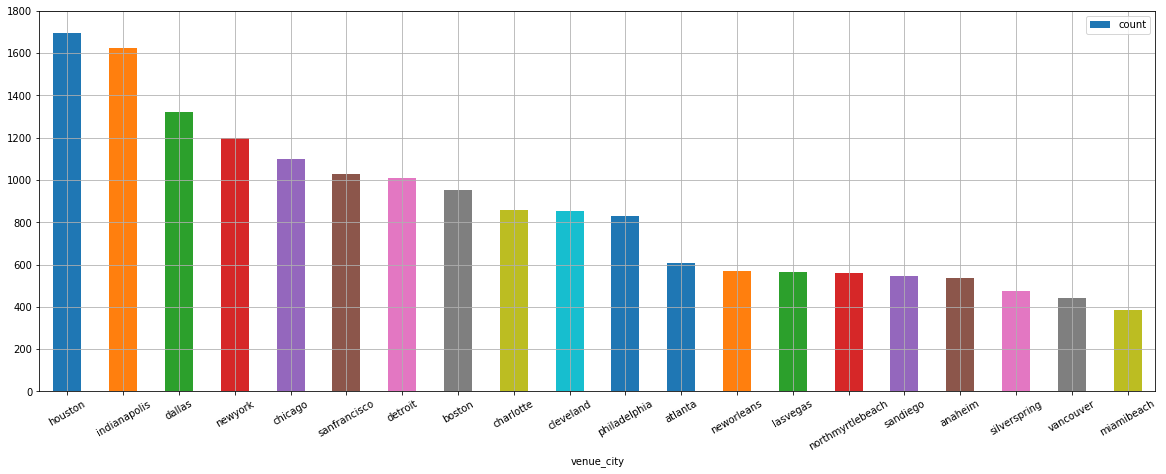

In [30]:
df_city1 = df_city.groupby('venue_city').count().sort("count").orderBy(["count"], ascending=[0]).limit(20)
pdf4 = df_city1.toPandas()
# Bar chart - Top 10 venue cities based on total event amount
pdf4.plot(kind= 'bar', x='venue_city', y='count', figsize=(20,7), grid=True, rot=30, ylim=(0, 1800))

In [31]:
#Identify the most popular event venue city based on purchased tickets amount
df_city.groupby('venue_city').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).show(3)

+------------+--------------------------+
|  venue_city|sum(tickets_purchased_qty)|
+------------+--------------------------+
|     houston|                    3279.0|
|indianapolis|                    2973.0|
|      dallas|                    2519.0|
+------------+--------------------------+
only showing top 3 rows



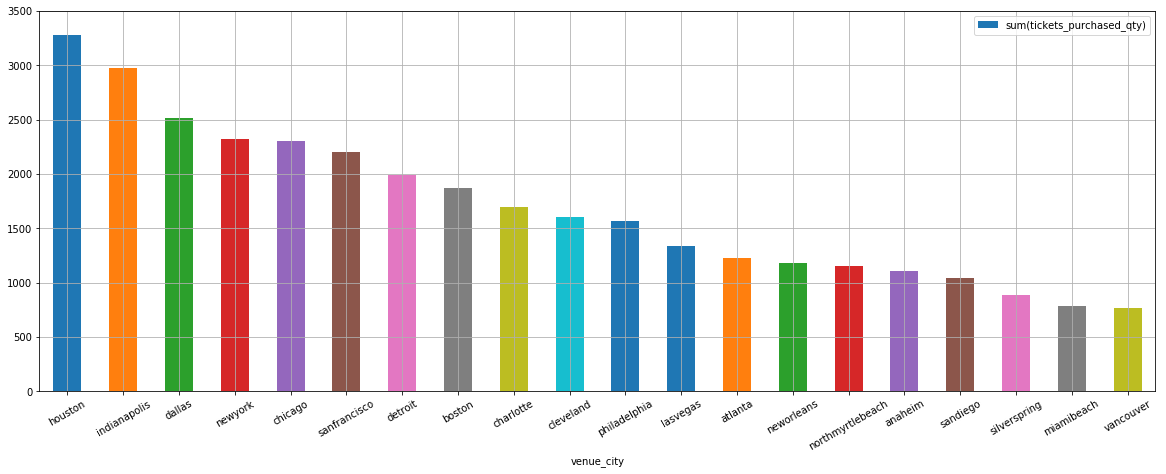

In [32]:
df_city2 = df_city.groupby('venue_city').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).limit(20)
pdf4_2 = df_city2.toPandas()
# Bar chart - Top 10 venue cities based on purchased tickets amount
pdf4_2.plot(kind= 'bar', x='venue_city', y='sum(tickets_purchased_qty)', figsize=(20,7), grid=True, rot=30, ylim=(0, 3500))

In [33]:
#Identify the most popular event venue city based on transactions amount
df2.groupby('venue_city').count().sort("count").orderBy(["count"], ascending=[0]).show(3)

+----------+-----+
|venue_city|count|
+----------+-----+
|    quincy|39122|
|   newyork|32320|
|    dallas|26958|
+----------+-----+
only showing top 3 rows



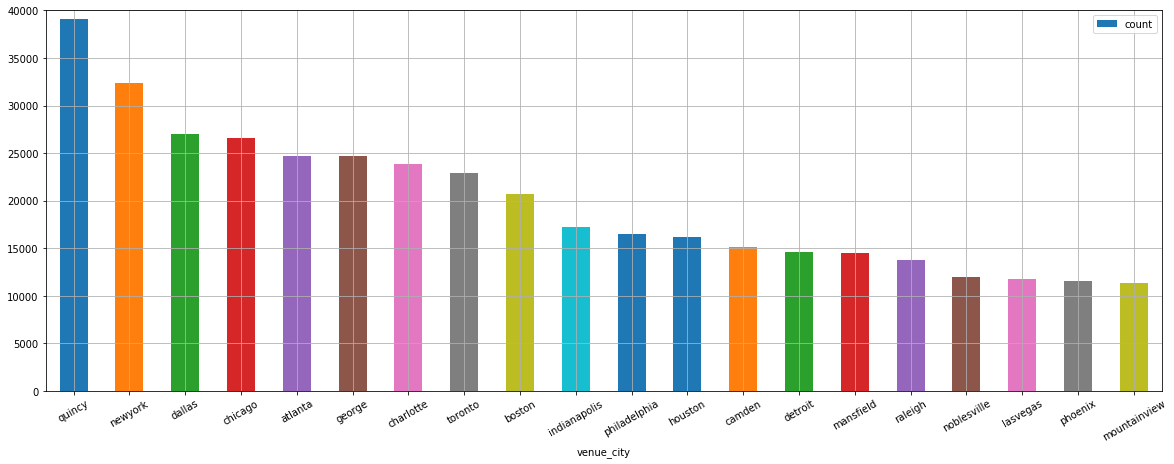

In [34]:
df_city3 = df2.groupby('venue_city').count().sort("count").orderBy(["count"], ascending=[0]).limit(20)
pdf4_3 = df_city3.toPandas()
# Bar chart - Top 10 venue cities based on transactions amount
pdf4_3.plot(kind= 'bar', x='venue_city', y='count', figsize=(20,7), grid=True, rot=30, ylim=(0, 40000))

# Customer Segmentation

#### Identify Users With Most Transactions

In [35]:
#count the number of purchasing parties
df2.select('purch_party_lkup_id').distinct().count()

759025

In [36]:
# Which purchasing party bought the most
df2.groupby('purch_party_lkup_id').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).show(3)

+--------------------+--------------------------+
| purch_party_lkup_id|sum(tickets_purchased_qty)|
+--------------------+--------------------------+
|df28610cb784bc422f95|                    1128.0|
|4d8723984f7408396e82|                     990.0|
|da7b0394df059e3066a6|                     620.0|
+--------------------+--------------------------+
only showing top 3 rows



In [37]:
# concatenate 'Year' and 'Month' columns and add 'Year_Month' column
from pyspark.sql.functions import concat, col, lit
from pyspark.sql import functions as sf
df_m = df_m.withColumn('Year_Month', sf.concat(sf.col("Year"), sf.lit(" "), sf.col("Month")))
# Group by 'purchasing party' and 'Year_Month'
df_m1 = df_m.groupBy('purch_party_lkup_id','Year_Month').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0, 0])
df_m1.show(5)

+--------------------+----------+--------------------------+
| purch_party_lkup_id|Year_Month|sum(tickets_purchased_qty)|
+--------------------+----------+--------------------------+
|f0d85fe5e1730f6dee21|    2015 6|                     471.0|
|352564b3082f4f1fbf77|    2015 7|                     332.0|
|3d8ebc7b51c46c5e91c3|    2016 1|                     326.0|
|ca69cc2b88c91ad400ce|    2016 2|                     300.0|
|f9793fafd5834d68183c|    2016 2|                     277.0|
+--------------------+----------+--------------------------+
only showing top 5 rows



In [38]:
# Identify which purchasing party bought the most per month per year(True fans?)
df_m2 = df_m1.groupBy('purch_party_lkup_id').agg(F.avg('sum(tickets_purchased_qty)')).dropna().sort(['avg(sum(tickets_purchased_qty))']).orderBy(['avg(sum(tickets_purchased_qty))'], ascending=[0])
df_m2.show(3)

+--------------------+-------------------------------+
| purch_party_lkup_id|avg(sum(tickets_purchased_qty))|
+--------------------+-------------------------------+
|d432f575ff42c643ca19|                          160.5|
|8dcc8d642af965b6918c|                          155.0|
|f9793fafd5834d68183c|             148.33333333333334|
+--------------------+-------------------------------+
only showing top 3 rows



#### Identify The Resellers 

In [39]:
# calculate the gap between event date and transaction date
from pyspark.sql import functions as F
df_diff = df2.withColumn('date_diff', F.datediff(F.to_date(df2.event_dt), F.to_date(df2.sales_ord_tran_dt)))
# add "<10000" here since date_diff larger than 10000 days is unreasonable
df_diff1 = df_diff.select('purch_party_lkup_id', 'date_diff').sort("date_diff").orderBy(["date_diff"], ascending=[0]).filter(col('date_diff')<10000).filter(col('date_diff')>180)
df_diff1.show(3)

+--------------------+---------+
| purch_party_lkup_id|date_diff|
+--------------------+---------+
|5b8e3c4287cf4b89eac8|      833|
|57192fcabb0cf46d543f|      833|
|c329597d21da14b129ce|      833|
+--------------------+---------+
only showing top 3 rows



In [40]:
# calculate the total purchasing amount for each purchaing party
df_qty = df2.groupby('purch_party_lkup_id').agg(F.sum('tickets_purchased_qty')).orderBy(["sum(tickets_purchased_qty)"], ascending=[0]).filter(col('sum(tickets_purchased_qty)')>240)
df_qty.show(3)

+--------------------+--------------------------+
| purch_party_lkup_id|sum(tickets_purchased_qty)|
+--------------------+--------------------------+
|df28610cb784bc422f95|                    1128.0|
|4d8723984f7408396e82|                     990.0|
|da7b0394df059e3066a6|                     620.0|
+--------------------+--------------------------+
only showing top 3 rows



In [41]:
# Identify the resellers
df_reseller = df_qty.join(df_diff1, df_qty['purch_party_lkup_id'] ==df_diff1['purch_party_lkup_id'], 'inner')
df_reseller.show(5)

+--------------------+--------------------------+--------------------+---------+
| purch_party_lkup_id|sum(tickets_purchased_qty)| purch_party_lkup_id|date_diff|
+--------------------+--------------------------+--------------------+---------+
|e10df8e50306794ede7b|                     397.0|e10df8e50306794ede7b|      750|
|4791733b8ac13c884426|                     241.0|4791733b8ac13c884426|      320|
|4791733b8ac13c884426|                     241.0|4791733b8ac13c884426|      191|
|db96782cafc6e74ad2cd|                     259.0|db96782cafc6e74ad2cd|      193|
|db96782cafc6e74ad2cd|                     259.0|db96782cafc6e74ad2cd|      233|
+--------------------+--------------------------+--------------------+---------+
only showing top 5 rows



### Factors that affect Customer Segmentation

In [42]:
# how many buyers in total
df3 = df1.groupby('purch_party_lkup_id').count()
df3.count()

759025

In [43]:
# Identify and compare one-time buyers and non one-time buyers
df4 = df1.groupby('purch_party_lkup_id','gndr_cd','age_yr','income_amt','edu_val','adults_in_hh_num','married_ind','child_present_ind','home_owner_ind').count()
df4.show(5)

+--------------------+-------+------+----------+-----------+----------------+-----------+-----------------+--------------+-----+
| purch_party_lkup_id|gndr_cd|age_yr|income_amt|    edu_val|adults_in_hh_num|married_ind|child_present_ind|home_owner_ind|count|
+--------------------+-------+------+----------+-----------+----------------+-----------+-----------------+--------------+-----+
|e01fe46387a95532fff0|     NA|    NA|        NA|         NA|              NA|         NA|               NA|            NA|    1|
|8e36bdc005e015d2e173|      M|    70|     87500|       NULL|               5|          1|                0|             1|    1|
|cbfd5e60d6a6eef09370|      F|    24|    112500|High School|               3|          1|                0|             1|    1|
|f136ee204abd8ac2df3c|      M|    26|     62500|High School|               2|          1|             NULL|          NULL|    1|
|8df1d7e409a0593f7851|   NULL|  NULL|      NULL|       NULL|            NULL|       NULL|        

In [44]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *
import numpy as np;
import pandas as pd;

import matplotlib.pyplot as plt
%matplotlib inline
def labelForResults(s):
    if s == 1:
        return 1.0
    else:
        return 0.0

In [45]:
label_fun = UserDefinedFunction(labelForResults, DoubleType())
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData1 = df4.select(label(df4["count"]).alias('label'), df4.purch_party_lkup_id, df4.gndr_cd, df4.age_yr, df4.income_amt, df4.edu_val, df4.adults_in_hh_num, df4.married_ind, df4.child_present_ind, df4.home_owner_ind)
# Identify one time buyer or non one time buyer
df_onetime = labeledData1.filter(labeledData1['label']==1)
df_nononetime = labeledData1.filter(labeledData1['label']!=1)

In [46]:
# how many one time buyers
pdf5 = df_onetime.describe().toPandas()
df_onetime.count()

709489

In [47]:
# how many non one time buyers
pdf6 = df_nononetime.describe().toPandas()
df_nononetime.count()

52401

In [48]:
# Mean age comparison between one time buyers and non one time buyers
objects = ('One Time Buyer', 'Non One Time Buyer')
y = np.arange(len(objects))
age_comparison = [float(pdf5.loc[1,'age_yr']), float(pdf6.loc[1,'age_yr'])]
age_comparison

[43.48112338858195, 46.10344827586207]

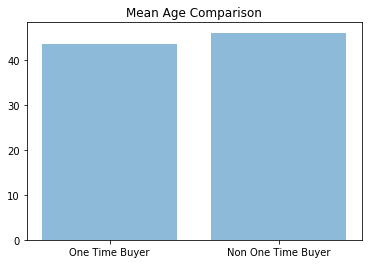

In [49]:
# bar chart - Mean age comparison 
plt.bar(y, age_comparison, align='center', alpha=0.5)
plt.xticks(y, objects)
plt.title('Mean Age Comparison')
plt.show()

In [50]:
# Mean income amount comparison between one time buyers and non one time buyers
income_comparison = [float(pdf5.loc[1,'income_amt']), float(pdf6.loc[1,'income_amt'])]
income_comparison

[85403.87518872673, 89125.0]

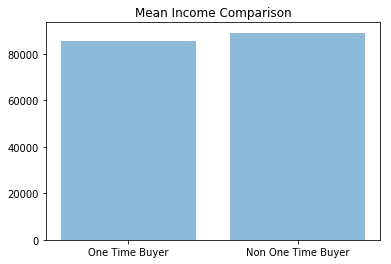

In [51]:
# bar chart - Mean income comparison 
plt.bar(y, income_comparison, align='center', alpha=0.5)
plt.xticks(y, objects)
plt.title('Mean Income Comparison')
plt.show()

In [52]:
# Mean adults in the purchase comparison between one time buyers and non one time buyers
adultsamount_comparison = [float(pdf5.loc[1,'adults_in_hh_num']), float(pdf6.loc[1,'adults_in_hh_num'])]
adultsamount_comparison

[2.3622047244094486, 2.55]

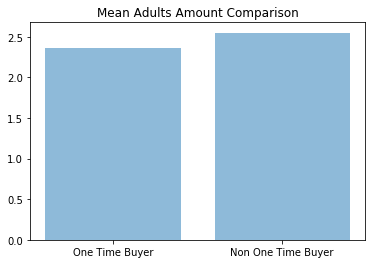

In [53]:
# bar chart - Mean adults in the purchase comparison 
plt.bar(y, adultsamount_comparison, align='center', alpha=0.5)
plt.xticks(y, objects)
plt.title('Mean Adults Amount Comparison')
plt.show()

In [54]:
# Mean married possibility comparison between one time buyers and non one time buyers
marriedpossibility_comparison = [float(pdf5.loc[1,'married_ind']), float(pdf6.loc[1,'married_ind'])]
marriedpossibility_comparison

[0.5854007633587787, 0.6607142857142857]

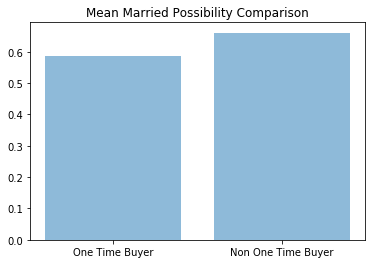

In [55]:
# bar chart - Mean married possibility in the purchase comparison 
plt.bar(y, marriedpossibility_comparison, align='center', alpha=0.5)
plt.xticks(y, objects)
plt.title('Mean Married Possibility Comparison')
plt.show()

In [56]:
# Mean children possibility comparison between one time buyers and non one time buyers
childrenpossibility_comparison = [float(pdf5.loc[1,'child_present_ind']), float(pdf6.loc[1,'child_present_ind'])]
childrenpossibility_comparison

[0.6599216710182768, 0.5957446808510638]

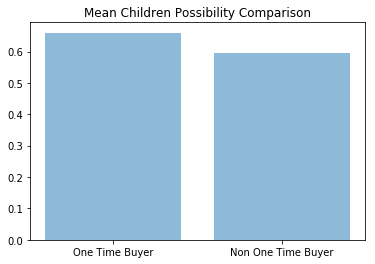

In [57]:
# bar chart - Mean children possibility in the purchase comparison 
plt.bar(y, childrenpossibility_comparison, align='center', alpha=0.5)
plt.xticks(y, objects)
plt.title('Mean Children Possibility Comparison')
plt.show()

In [58]:
# Mean home owner possibility comparison between one time buyers and non one time buyers
homeownerpossibility_comparison = [float(pdf5.loc[1,'home_owner_ind']), float(pdf6.loc[1,'home_owner_ind'])]
homeownerpossibility_comparison
pdf5.loc[1,'home_owner_ind'], pdf6.loc[1,'home_owner_ind']

('0.9559420289855073', '0.9038461538461539')

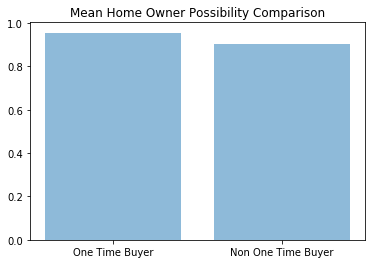

In [59]:
# bar chart - Mean children possibility in the purchase comparison 
plt.bar(y, homeownerpossibility_comparison, align='center', alpha=0.5)
plt.xticks(y, objects)
plt.title('Mean Home Owner Possibility Comparison')
plt.show()

In [60]:
# Gender comparison between one time buyers and non one time buyers

df_onetime.filter(df_onetime['gndr_cd'] == 'M').count()

1081

In [61]:
df_onetime.filter(df_onetime['gndr_cd'] == 'F').count()

1259

In [62]:
df_nononetime.filter(df_nononetime['gndr_cd'] == 'M').count()

30

In [63]:
df_nononetime.filter(df_nononetime['gndr_cd'] == 'F').count()

32

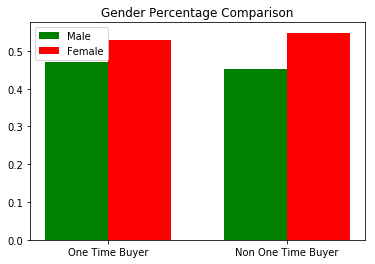

In [64]:
# bar chart - gender percentage comparison

gendercomparision_m = (9299/(9299+10449), 169/(169+205))
gendercomparision_f = (10449/(9299+10449), 205/(169+205))

fig, ax = plt.subplots()

ind = np.arange(2)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, gendercomparision_m, width, color='g')
p2 = ax.bar(ind + width, gendercomparision_f, width,color='r')

ax.set_title('Gender Percentage Comparison')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('One Time Buyer', 'Non One Time Buyer'))

ax.legend((p1[0], p2[0]), ('Male', 'Female'))
ax.autoscale_view()

plt.show()

In [65]:
df_onetime.select('edu_val').distinct().show()

+---------------+
|        edu_val|
+---------------+
|    High School|
|             NA|
|        College|
|Graduate School|
|           NULL|
+---------------+



In [66]:
df_onetime.filter(df_onetime['edu_val'] == 'High School').count()

1007

In [67]:
df_onetime.filter(df_onetime['edu_val'] == 'College').count()

570

In [68]:
df_onetime.filter(df_onetime['edu_val'] == 'Graduate School').count()

224

In [69]:
df_nononetime.filter(df_nononetime['edu_val'] == 'High School').count()

21

In [70]:
df_nononetime.filter(df_nononetime['edu_val'] == 'College').count()

11

In [71]:
df_nononetime.filter(df_nononetime['edu_val'] == 'Graduate School').count()

12

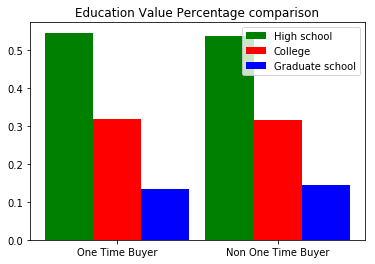

In [72]:
# bar chart - Education Value Percentage comparison

highschool = (8345/(8345+4867+2051), 167/(167+98+45))
college = (4867/(8345+4867+2051), 98/(167+98+45))
graduateschool = (2051/(8345+4867+2051), 45/(167+98+45))

fig, ax = plt.subplots()

ind = np.arange(2)    # the x locations for the groups
width = 0.3         # the width of the bars
p1 = ax.bar(ind, highschool, width, color='g')
p2 = ax.bar(ind + width, college, width,color='r')
p3 = ax.bar(ind + width + width, graduateschool, width,color='b')

ax.set_title('Education Value Percentage comparison')
ax.set_xticks(ind + width )
ax.set_xticklabels(('One Time Buyer', 'Non One Time Buyer'))

ax.legend((p1[0], p2[0],p3[0]), ('High school', 'College', 'Graduate school'))
ax.autoscale_view()

plt.show()

### Machine Learning For Customer Segmentation

In [73]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
df6 = df1.groupby('purch_party_lkup_id','gndr_cd','age_yr','income_amt','edu_val','adults_in_hh_num','married_ind','child_present_ind','home_owner_ind').count()

In [75]:
df6.count()

761890

In [76]:
df6.show(5)

+--------------------+-------+------+----------+-------+----------------+-----------+-----------------+--------------+-----+
| purch_party_lkup_id|gndr_cd|age_yr|income_amt|edu_val|adults_in_hh_num|married_ind|child_present_ind|home_owner_ind|count|
+--------------------+-------+------+----------+-------+----------------+-----------+-----------------+--------------+-----+
|c21d9746a56f3f20ae7c|     NA|    NA|        NA|     NA|              NA|         NA|               NA|            NA|    1|
|6d8cc3eac142dc5e5915|     NA|    NA|        NA|     NA|              NA|         NA|               NA|            NA|    1|
|6f2579eebb04fbb5ba54|     NA|    NA|        NA|     NA|              NA|         NA|               NA|            NA|    2|
|faec1a44efae6347d17e|     NA|    NA|        NA|     NA|              NA|         NA|               NA|            NA|    1|
|1a850202ddcafad5e705|     NA|    NA|        NA|     NA|              NA|         NA|               NA|            NA|    1|


In [77]:
df7=df6.filter(df6['gndr_cd']!='NA').filter(df6['age_yr']!='NA').filter(df6['income_amt']!='NA').filter(df6['edu_val']!='NA')
df8=df7.filter(df7['gndr_cd']!='NULL').filter(df7['age_yr']!='NULL').filter(df7['income_amt']!='NULL').filter(df7['edu_val']!='NULL')
df8.count()

1593

In [78]:
df8.show(5)

+--------------------+-------+------+----------+-----------+----------------+-----------+-----------------+--------------+-----+
| purch_party_lkup_id|gndr_cd|age_yr|income_amt|    edu_val|adults_in_hh_num|married_ind|child_present_ind|home_owner_ind|count|
+--------------------+-------+------+----------+-----------+----------------+-----------+-----------------+--------------+-----+
|cbfd5e60d6a6eef09370|      F|    24|    112500|High School|               3|          1|                0|             1|    1|
|f136ee204abd8ac2df3c|      M|    26|     62500|High School|               2|          1|             NULL|          NULL|    1|
|e6cec104475d3668243e|      M|    32|     25000|High School|               1|          0|             NULL|             1|    1|
|c98d11b9c92da4b52b06|      F|    40|     45000|High School|               2|          0|                1|             1|    1|
|5ad8406fad806b63f9ba|      M|    26|    200000|High School|               2|          1|        

In [79]:
from pyspark.sql.types import IntegerType
df8 = df8.withColumn("age_yr", df8["age_yr"].cast(IntegerType()))
df8 = df8.withColumn("income_amt", df8["income_amt"].cast(IntegerType()))

In [80]:
min_age_yr = df8.agg({"age_yr": "min"}).collect()[0][0]
max_age_yr = df8.agg({"age_yr": "max"}).collect()[0][0]
mean_age_yr = df8.agg({"age_yr": "mean"}).collect()[0][0]

print ("Minimum Age : ", min_age_yr, ", Maximum Age : ",max_age_yr, ", Mean Age : ", mean_age_yr)

Minimum Age :  18 , Maximum Age :  92 , Mean Age :  44.067796610169495


In [81]:
df8 = df8.withColumn('age_norm', (df8["age_yr"] - min_age_yr)/ ( max_age_yr  - min_age_yr))

In [82]:
min_income_amt = df8.agg({"income_amt": "min"}).collect()[0][0]
max_income_amt = df8.agg({"income_amt": "max"}).collect()[0][0]
mean_income_amt = df8.agg({"income_amt": "mean"}).collect()[0][0]

print ("Minimum Income : ", min_income_amt, ", Maximum Income : ",max_income_amt, ", Mean Income : ", mean_income_amt)

Minimum Income :  10000 , Maximum Income :  200000 , Mean Income :  86111.11111111111


In [83]:
df8 = df8.withColumn('income_norm', (df8["income_amt"] - min_income_amt)/ ( max_income_amt  - min_income_amt))

In [84]:
# classify one-time buyer
def labelForResults(s):
    if s == 1:
        return 1.0
    else:
        return 0.0
    
label_fun = UserDefinedFunction(labelForResults, DoubleType())
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df8.select(label(df8["count"]).alias('label'),df8.gndr_cd,df8.age_norm,df8.income_norm, df8.edu_val)

In [85]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
#convert relevant categorical into one hot encoded
indexer1 = StringIndexer(inputCol="gndr_cd", outputCol="gndr_cdIdx").setHandleInvalid("skip")
#indexer2 = StringIndexer(inputCol="edu_val", outputCol="edu_valIdx").setHandleInvalid("skip")
#indexer3 = StringIndexer(inputCol="adults_in_hh_num", outputCol="adults_in_hh_numIdx").setHandleInvalid("skip")
#indexer4 = StringIndexer(inputCol="home_owner_ind", outputCol="home_owner_indIdx").setHandleInvalid("skip")

#gather all indexers as inputs to the One Hot Encoder
inputs = [indexer1.getOutputCol()]

#create the one hot encoder
encoder = OneHotEncoderEstimator(inputCols=inputs,  \
                                 outputCols=["gndr_cdVec"])

#run it through a pipeline
pipeline = Pipeline(stages=[indexer1, encoder])
pipeline = pipeline.fit(labeledData).transform(labeledData)
#we have removed NAs so dont need to impute missing values.
#pipeline = pipeline.na.fill(0) 

#pipeline.show(5)

In [86]:
#gather feature vector and identify features
assembler = VectorAssembler(inputCols = ['gndr_cdVec', \
                                          'age_norm', 'income_norm'], \
                            outputCol = 'features')
pipeline = assembler.transform(pipeline)

In [97]:
train_df, test_df = pipeline.randomSplit([.8,.2],seed=1234)
#train_df.show(1)

##### Logistic Regression Model

In [88]:
%%time
from pyspark.ml.classification import LogisticRegression

# Set parameters for Logistic Regression
lgr = LogisticRegression(maxIter=10, featuresCol = 'features', labelCol='label')

# Fit the model to the data.
lgrm = lgr.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
predictions = lgrm.transform(test_df)

CPU times: user 148 ms, sys: 100 ms, total: 248 ms
Wall time: 8.18 s


In [89]:
#compare predictions against true labels
#predictions.select("gndr_cd", "age_norm", "income_norm", "prediction").show(10)

In [90]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.9704918032786886
0.9559586481547149


##### Random Forest Model

In [98]:
%%time
from pyspark.ml.classification import RandomForestClassifier

# Set parameters for the Random Forest.
rfc = RandomForestClassifier(maxDepth=5, numTrees=15, impurity="gini", labelCol="label", predictionCol="prediction")

# Fit the model to the data.
rfcm = rfc.fit(train_df)

# Given a dataset, predict each point's label, and show the results.
predictions = rfcm.transform(test_df)

CPU times: user 138 ms, sys: 96.8 ms, total: 235 ms
Wall time: 35.5 s


In [99]:
#predictions.select("gndr_cd", "age_norm", "income_norm", "prediction").show(10)

In [100]:
predictions2 = rfcm.transform(test_df)

In [101]:
print(evaluator.evaluate(predictions2, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions2, {evaluator.metricName: "f1"}))

0.967948717948718
0.9521840808485759


In [122]:
# We ran five times for random forest model by resampling the training dataset, and cross validation accuracy is around 96.5%.

# Advertisment 

#### Analysis By Campaign

In [123]:
df_ad = spark.read.csv("/user/yuyangzh/final/adwords.csv", inferSchema=True, header=True)

from pyspark.sql.functions import lower, col
df_ad = df_ad.withColumn('campaign', lower(col('campaign'))).withColumn('ad_group', lower(col('ad_group'))).withColumn('keyword', lower(col('keyword')))

In [124]:
from pyspark.sql.functions import udf

charReplace = udf(lambda x: x.replace(u' ',''))
df_ad = df_ad.withColumn('campaign',charReplace('campaign')).withColumn('ad_group',charReplace('ad_group')).withColumn('keyword',charReplace('keyword'))
df_ad.show(5)


+--------------------+----------+--------+----------+-------+-------------------+--------------------+-------------+----------+-------+------+-----------+-------+-------+-------+----+------------+-------------+--------------+------------------+----------------+---------------------+--------------------+--------------+----------------+-----------+----------+---------+
|         campaign_id|adgroup_id|ad_group|  campaign|account|               week|             keyword|keyword.state|match.type|max_cpc|clicks|impressions|    ctr|avg_cpc|avg_cpm|cost|avg_position|quality.score|first.page.cpc|first.position.cpc|converted.clicks|click.conversion.rate|cost.converted.click|cost.all.conv.|total.conv.value|conversions|cost.conv.|conv.rate|
+--------------------+----------+--------+----------+-------+-------------------+--------------------+-------------+----------+-------+------+-----------+-------+-------+-------+----+------------+-------------+--------------+------------------+----------------

In [125]:
df_ad.count()

1451987

In [126]:
df_ad_cam_sales_avg =  df_ad.groupBy('campaign').agg(F.avg('conversions')).dropna()
df_ad_cam_sales_avg_top=df_ad_cam_sales_avg.orderBy(["avg(conversions)"], ascending=[0, 0]).limit(5)
df_ad_cam_sales_avg_top.show()

+--------------------+------------------+
|            campaign|  avg(conversions)|
+--------------------+------------------+
|brand-ticketmaste...| 106.7605633802817|
|  brand-ticketmaster| 57.85448916408669|
|brand-ticketmaste...| 49.23529411764706|
|brand-ticketmaste...| 45.16428571428571|
|brand-ticketmaste...|26.678195488721805|
+--------------------+------------------+



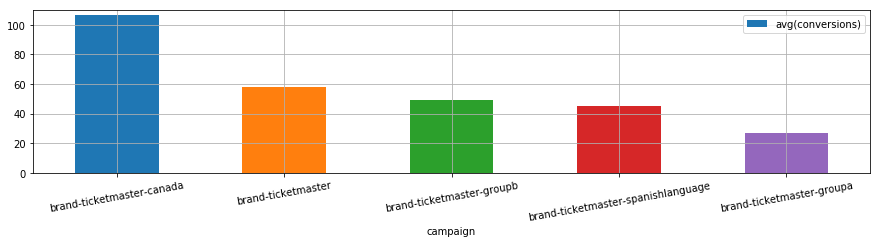

In [127]:
pdf4_cam_sales_top = df_ad_cam_sales_avg_top.toPandas()
pdf4_cam_sales_top.plot(kind= 'bar', x='campaign', y='avg(conversions)', figsize=(15,3), grid=True, rot=10, ylim=(0, 110))

#### Analysis By subAD

In [128]:
df_ad_group_sales_avg =  df_ad.groupBy('ad_group').agg(F.avg('conversions')).dropna()
df_ad_group_sales_avg_top=df_ad_group_sales_avg.orderBy(["avg(conversions)"], ascending=[0, 0]).limit(5)
df_ad_group_sales_avg_top.show()

+--------------------+------------------+
|            ad_group|  avg(conversions)|
+--------------------+------------------+
|  kevinhart(general)|            241.25|
|   hamilton(general)| 163.1931818181818|
|fleetwoodmac(gene...|            156.55|
|zacbrownband(gene...| 107.5421686746988|
|ticketmaster(targ...|102.47916666666667|
+--------------------+------------------+



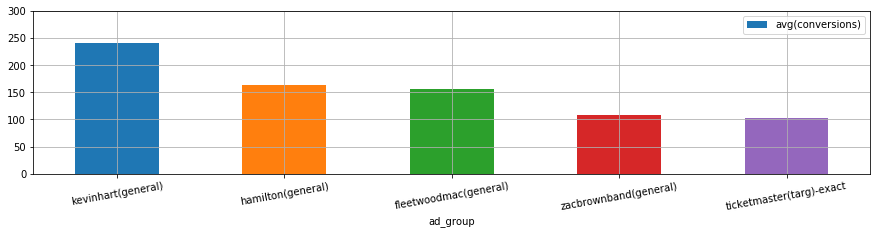

In [129]:
pdf_ad_sales_top = df_ad_group_sales_avg_top.toPandas()
pdf_ad_sales_top.plot(kind= 'bar', x='ad_group', y='avg(conversions)', figsize=(15,3), grid=True, rot=10, ylim=(0, 300))

#### Analysis By Keywords

In [130]:
df_ad_key_sales_avg =  df_ad.groupBy('keyword').agg(F.avg('conversions')).dropna()
df_ad_key_sales_avg_top= df_ad_key_sales_avg.orderBy(["avg(conversions)"], ascending=[0, 0]).limit(5)
df_ad_key_sales_avg_top.show()

+--------------------+------------------+
|             keyword|  avg(conversions)|
+--------------------+------------------+
| """""kevinhart"""""|            241.25|
|  """""hamilton"""""| 163.1931818181818|
|"""""fleetwoodmac...|            156.55|
|[ticketmasteroffi...|156.23636363636365|
|"""""ticketmaster...|            148.25|
+--------------------+------------------+



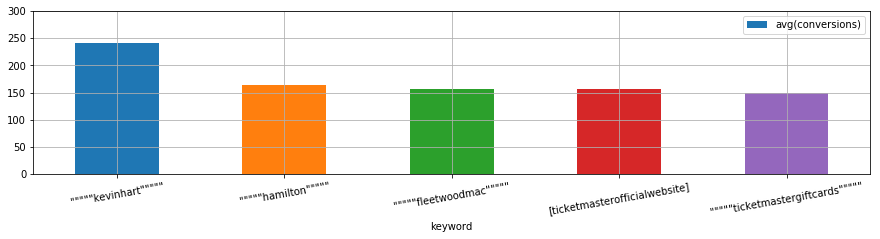

In [131]:
pdf_key_sales_top = df_ad_key_sales_avg_top.toPandas()
pdf_key_sales_top.plot(kind= 'bar', x='keyword', y='avg(conversions)', figsize=(15,3), grid=True, rot=10, ylim=(0, 300))

#### Analysis By Refer Site

In [132]:
df_ga = spark.read.csv("/user/yuyangzh/final/ga_data.csv", inferSchema=True, header=True)
df_ga.count()

4225456

In [133]:
df_ga_source_sum =  df_ga.groupBy('source').agg(F.sum('totals_visits')).dropna()
df_ga_source_sum_top=df_ga_source_sum .orderBy(["sum(totals_visits)"], ascending=[0, 0]).limit(10)
df_ga_source_sum_top.show()

+--------------------+------------------+
|              source|sum(totals_visits)|
+--------------------+------------------+
|              google|           1776645|
|            (direct)|           1301125|
|           (not set)|            136349|
|      m.facebook.com|             75853|
|                bing|             73866|
|               yahoo|             73752|
|     187101-Facebook|             56914|
|   97249-Bandsintown|             46835|
|        coldplay.com|             35155|
|73074-Songkick.co...|             33866|
+--------------------+------------------+



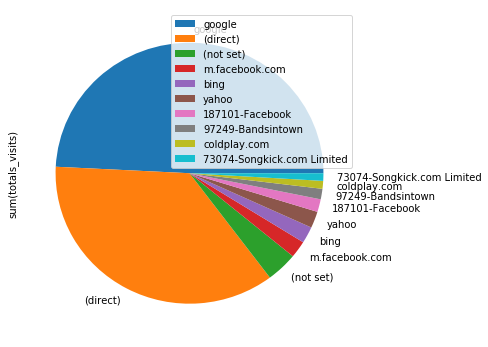

In [134]:
pdf_ga_source = df_ga_source_sum_top.toPandas()
pdf_ga_source.plot.pie(y='sum(totals_visits)', labels = pdf_ga_source['source'], figsize=(6, 6))

#### Ga Table Joined with Advertisment Table (interaction between goolge campaign and ticket_master official website visiting)

In [135]:
df_ad_id = df_ad.groupby('campaign_id','campaign').count()
df_ad_id.show(5)

+--------------------+--------------------+-----+
|         campaign_id|            campaign|count|
+--------------------+--------------------+-----+
|                  NA|        nflbaltimore|  657|
|                  NA|      gg:horseracing|  487|
|                  NA|       z-bettemidler| 1282|
|ebe4628791bcadedf719|             detroit| 1201|
|                  NA|nba-phoenixsuns(p...|   68|
+--------------------+--------------------+-----+
only showing top 5 rows



In [136]:
df_ad_combine=df_ga.join(df_ad_id, df_ga["campaign_id"] == df_ad_id["campaign_id"],"left_outer")

In [137]:
# Total google visit
df_ad_combine.filter(df_ad_combine['source']=='google').count()
# Total google visit through campaign
df_ad_combine.filter(df_ad_combine['source']=='google').filter(df_ad_combine['campaign'] != "NULL").count()
percent=df_ad_combine.filter(df_ad_combine['source']=='google').filter(df_ad_combine['campaign'] != "NULL").count()/df_ad_combine.filter(df_ad_combine['source']=='google').count()
percent

0.0813370144288814

In [138]:
# filter to visit_google_cam and analyze keywords
df_ad_combine_google_cam=df_ad_combine.filter(df_ad_combine['source']=='google').filter(df_ad_combine['campaign'] != "NULL")

In [139]:
df_ad_combine_google_cam_sum =  df_ad_combine_google_cam.groupBy('campaign').agg(F.sum('totals_visits')).dropna()
df_ad_combine_google_cam_sum_top=df_ad_combine_google_cam_sum.orderBy(["sum(totals_visits)"], ascending=[0, 0]).limit(5)

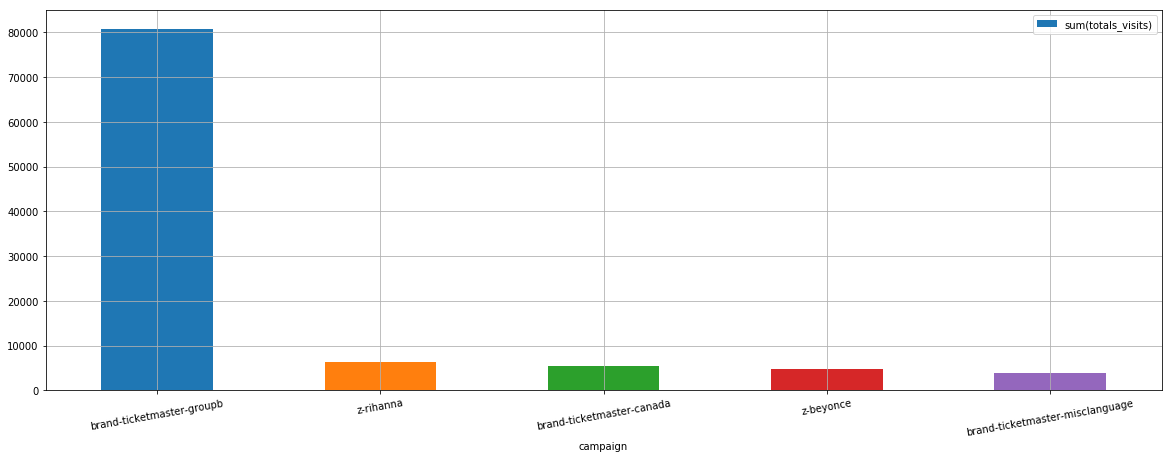

In [140]:
pdf_ad_combine_google_cam_sum_top = df_ad_combine_google_cam_sum_top.toPandas()
pdf_ad_combine_google_cam_sum_top.plot(kind= 'bar', x='campaign', y='sum(totals_visits)', figsize=(20,7), grid=True, rot=10, ylim=(0, 85000))

#### Analysis By Device

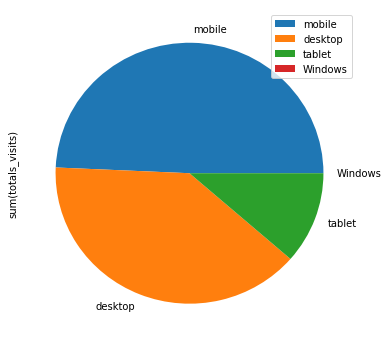

In [141]:
df_ga_devicecategory_sum =  df_ga.groupBy('device_devicecategory').agg(F.sum('totals_visits')).dropna()
df_ga_devicecategory_sum_top=df_ga_devicecategory_sum .orderBy(["sum(totals_visits)"], ascending=[0, 0]).limit(4)

pdf_ga_devicecategory = df_ga_devicecategory_sum_top.toPandas()
pdf_ga_devicecategory.plot.pie(y='sum(totals_visits)', labels = pdf_ga_devicecategory ['device_devicecategory'], figsize=(6, 6))

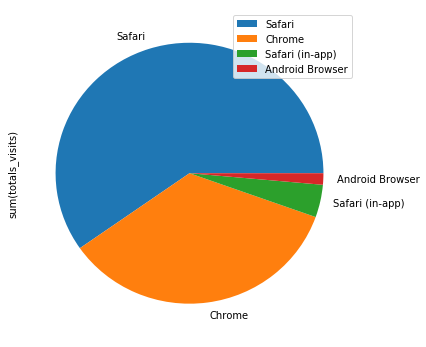

In [142]:
df_ga_devicebro_sum =  df_ga.filter(df_ad_combine['device_devicecategory']=='mobile').groupBy('device_browser').agg(F.sum('totals_visits')).dropna()
df_ga_devicebro_sum_top=df_ga_devicebro_sum .orderBy(["sum(totals_visits)"], ascending=[0, 0]).limit(4)

pdf_df_ga_devicebro_sum = df_ga_devicebro_sum_top.toPandas()
pdf_df_ga_devicebro_sum.plot.pie(y='sum(totals_visits)', labels = pdf_df_ga_devicebro_sum['device_browser'], figsize=(6, 6))